In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import plot_confusion_matrix
import matplotlib.patches as patches
import itertools
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import validation_curve



%matplotlib inline

In [105]:
MLdata= pd.read_csv('NewData/mutual_10BestSelection.csv')
pd.options.display.max_seq_items = None
MLdata.head()

,CASE_STATUS,CASE_SUBMITTED,SOC_CODE,FULL_TIME_POSITION,TOTAL_WORKER_POSITIONS,H-1B_DEPENDENT,NumOfNaN,PERIOD_OF_EMPLOYMENT_LENGTH,Annual_Wage,Fortune,EMPLOYER_REGION
0,1,1,15.0,1,0,0.0,4.0,3,2,0,2.0
1,1,2,13.0,1,0,0.0,4.0,3,0,0,3.0
2,1,2,15.0,1,0,1.0,13.0,3,2,0,3.0
3,1,2,17.0,1,0,0.0,5.0,3,1,1,2.0
4,1,0,15.0,1,0,0.0,15.0,3,2,1,2.0


In [106]:
# fill all the data with mode
for column in MLdata.columns:
    MLdata[column] = MLdata[column].fillna(MLdata[column].mode()[0])
    MLdata[column] = pd.to_numeric(MLdata[column]) # convert all columns of DataFrame to float

MLdata.isnull().sum()
xdata = MLdata.loc[:,MLdata.columns[1:]]
ydata = MLdata.loc[:,['CASE_STATUS']]

In [107]:
def Kfold(xdata,ydata,n_neighbors,leaf_size,p,n_splits):
    train_accuracy =[]
    test_accuracy = []
    ACC = []
    TPR = []
    TNR = []
    PPV = []
    f1 = []
    ConfusionBox = np.array([[0,0],[0,0]])
    cv = StratifiedKFold(n_splits=5,shuffle=False)

    for train,test in cv.split(xdata,ydata):
        xtrain = xdata.iloc[train]
        ytrain = ydata.iloc[train]
        xtest = xdata.iloc[test]
        ytest = ydata.iloc[test]
    
#####where you need to modify -------------------------------------------------------------------------    
        knn = KNeighborsClassifier(n_neighbors=n_neighbors,weights='distance',leaf_size=leaf_size,p=p)
        knn.fit(xtrain,np.ravel(ytrain))
        ypred = knn.predict(xtest)
        #Compute accuracy on the training set
        train_accuracy.append(knn.score(xtrain,ytrain))
        #Compute accuracy on the test set
        test_accuracy.append(knn.score(xtest,ytest))
#####where you need to modify -------------------------------------------------------------------------    

        
        CM = confusion_matrix(ytest,ypred)
        TN = CM[0][0]
        FN = CM[1][0]
        TP = CM[1][1]
        FP = CM[0][1]
        ConfusionBox += CM
        # Overall accuracy
        ACC.append((TP+TN)/(TP+FP+FN+TN))
        # Sensitivity, hit rate, recall, or true positive rate
        TPR.append(TP/(TP+FN))
        # Specificity or true negative rate
        TNR.append(TN/(TN+FP))
        # Precision or positive predictive value
        PPV.append(TP/(TP+FP))
        # f1 score
        f1.append(f1_score(ytest,ypred))
    
    return np.mean(train_accuracy),np.mean(test_accuracy),np.mean(ACC),np.mean(TPR),np.mean(TNR),np.mean(PPV),np.mean(f1),ConfusionBox

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#####where you need to modify -------------------------------------------------------------------------    
def KNNAucRocCurve(n_neighbors,leaf_size,p):
    knn = KNeighborsClassifier(n_neighbors=52,weights='distance',leaf_size=40,p=1)
    knn.fit(xtrain,np.ravel(ytrain))
    ypred = knn.predict_proba(xtest)[:,1]
#####where you need to modify -------------------------------------------------------------------------    
    
    fpr, tpr, thresholds = roc_curve(ytest, ypred)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr,tpr, label='Knn')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('KNN, K={}, ROC curve'.format(n_neighbors))
    plt.show()

Confusion matrix
[[ 2168  2995]
 [ 1520 13969]]


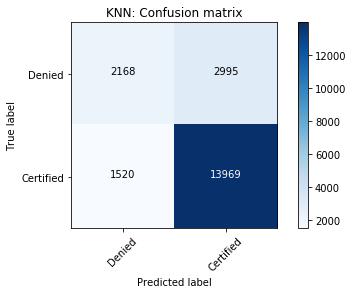

In [108]:
# Confusion Box
#####where you need to modify -------------------------------------------------------------------------    
train_accuracy,test_accuracy,ACC,TPR,TNR,PPV,f1,ConfusionBox=Kfold(xdata,ydata,n_neighbors=15,leaf_size=10,p=2,n_splits =5)
plt.figure()
plot_confusion_matrix(ConfusionBox,classes=['Denied','Certified'],title='KNN: Confusion matrix')
#####where you need to modify -------------------------------------------------------------------------    


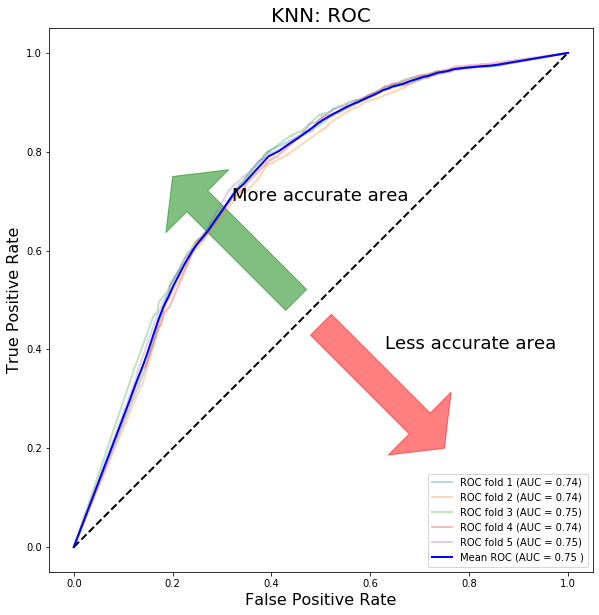

In [109]:
# ROC curve
random_state = np.random.RandomState(0)
cv = StratifiedKFold(n_splits=5,shuffle=False)
x = MLdata.loc[:,MLdata.columns[1:]]
y = MLdata.loc[:,['CASE_STATUS']]

# plot arrows
fig1 = plt.figure(figsize=[10,10])
ax1 = fig1.add_subplot(111,aspect = 'equal')
ax1.add_patch(patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5))
ax1.add_patch(patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5))
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1

#####where you need to modify -------------------------------------------------------------------------    
knn = KNeighborsClassifier(weights='distance',n_neighbors=15,leaf_size=10,p=2)
for train,test in cv.split(x,y):   
    
    prediction = knn.fit(x.iloc[train],np.ravel(y.iloc[train])).predict_proba(x.iloc[test])

#####where you need to modify -------------------------------------------------------------------------    

    fpr, tpr, t = roc_curve(y.iloc[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate',fontsize = 16)
plt.ylabel('True Positive Rate',fontsize = 16)
plt.title('KNN: ROC',fontsize = 20)
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 18)
plt.text(0.63,0.4,'Less accurate area',fontsize = 18)
plt.show()

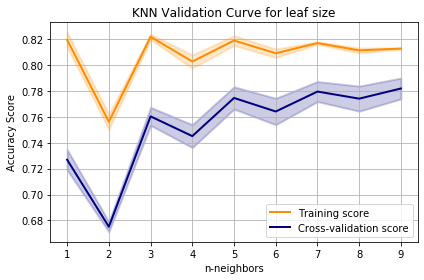

In [116]:
# validation curve
X = MLdata[MLdata.columns[1:]]
y = MLdata['CASE_STATUS']
cv = StratifiedKFold(4)
param_range = np.arange(1, 10, 1)
lw = 2
#####where you need to modify -------------------------------------------------------------------------    
train_scores, test_scores = validation_curve(KNeighborsClassifier(),X,y, param_name="n_neighbors",param_range=param_range, cv=cv)
#####where you need to modify -------------------------------------------------------------------------    


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range,train_scores_mean,label="Training score",color="darkorange",lw=lw)
plt.plot(param_range,test_scores_mean,label="Cross-validation score",color="navy", lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.2,color="darkorange", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.2,color="navy", lw=lw)
plt.title("KNN Validation Curve for leaf size")
plt.xlabel(r"n-neighbors")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()